<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Consumption needs of buildings - Project 4</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h2 style="width: 100%; text-align: center; float: left;" align="center">| Analysis notebook |</h2>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h3 style="width: 100%; text-align: center; font-size:26px; float: left;" align="center">Data Scientist course - OpenClassrooms</h3>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
# import os
import io
import gc
# import itertools
# import math
from math import prod
import pandas as pd
import numpy as np



import scipy.stats as stats
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
import seaborn as sns
# from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.impute import KNNImputer
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot


%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h4>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("display.max_colwidth", None) # show full width of showing cols
        pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell 
        
        if type_analysis is None or type_analysis != "complete":
            print("\n- Type object and records by columns      (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif type_analysis == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns      (",memory_usage,")")
            print("--------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        pd.reset_option("display.float_format") # reset show full content in cell 
        
        # deleting dataframe to free memory
        if type_analysis == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()

            
def normality_test(df):
    """
    Method used for make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
    
    On the other hand, we get the means of <b>Energy Star Score</b>
    <ul style="list-style-type: square;">
        <li><b>Energy Star Score: https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results</b></li>
    </ul>  
</div>

In [3]:
data_2015 = pd.read_csv(r"datasets\2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv(r"datasets\2016-building-energy-benchmarking.csv")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.2. Initial analysis</h4>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [4]:
df_analysis(data_2015, "data_2015")


Analysis of data_2015 dataset
--------------------------------------------------------------------
- Dataset shape:                  3340 rows and 47 columns
- Total of NaN values:            26512
- Percentage of NaN:              16.89 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3340,0,0.00000
9,YearBuilt,int64,3340,0,0.00000
40,ComplianceStatus,object,3340,0,0.00000
1,DataYear,int64,3340,0,0.00000
14,PropertyGFABuilding(s),int64,3340,0,0.00000
13,PropertyGFAParking,int64,3340,0,0.00000
12,PropertyGFATotal,int64,3340,0,0.00000
10,NumberofBuildings,int64,3340,0,0.00000
46,Zip Codes,int64,3340,0,0.00000
8,Neighborhood,object,3340,0,0.00000


In [5]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols

In [6]:
data_2015.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081


In [7]:
df_analysis(data_2016, "data_2016")


Analysis of data_2016 dataset
--------------------------------------------------------------------
- Dataset shape:                  3376 rows and 46 columns
- Total of NaN values:            19952
- Percentage of NaN:              12.85 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Comments']
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3376,0,0.00000
11,Neighborhood,object,3376,0,0.00000
1,DataYear,int64,3376,0,0.00000
40,DefaultData,bool,3376,0,0.00000
42,ComplianceStatus,object,3376,0,0.00000
19,PropertyGFABuilding(s),int64,3376,0,0.00000
18,PropertyGFAParking,int64,3376,0,0.00000
17,PropertyGFATotal,int64,3376,0,0.00000
14,YearBuilt,int64,3376,0,0.00000
13,Longitude,float64,3376,0,0.00000


In [8]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols

In [9]:
data_2016.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Cleaning</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.1. Formatting columns</h4>
</div>

In [10]:
data_2015.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
    
    In this way, we can <b>identify similar features</b> between datasets
    
     <ul style="list-style-type: square;">
        <li><b>GHGEmissions(MetricTonsCO2e)</b> in <b>data_2015</b> is the same feature as <b>TotalGHGEmissions</b> in <b>data_2016</b></li>
        <li><b>GHGEmissionsIntensity(kgCO2e/ft2)</b> in <b>data_2015</b> is the same feature as <b>GHGEmissionsIntensity</b> in <b>data_2016</b></li>
    </ul>
    
     On the other hands, we have the following
    <ul style="list-style-type: square;">
        <li><b>Zip Codes</b> in <b>data_2015</b> is the same feature as <b>ZipCode</b> in <b>data_2016</b></li>
    </ul>
</div>

In [11]:
data_2015["ZipCode"] = data_2015["Zip Codes"]
data_2016["GHGEmissionsIntensity(kgCO2e/ft2)"] = data_2016["GHGEmissionsIntensity"]
data_2016["GHGEmissions(MetricTonsCO2e)"] = data_2016["TotalGHGEmissions"]

data_2015.drop(labels=["Zip Codes"], axis=1, inplace=True)
data_2016.drop(labels=["GHGEmissionsIntensity", "TotalGHGEmissions"], axis=1, inplace=True)

<div class="alert alert-block alert-info">
<b>Comparing</b> the match between columns <b>before</b> making the <b>concatenation</b>
</div>

In [12]:
LIST_COL, LIST_ORIGIN = ([] for i in range(2))

for col in data_2015.columns:
    if col not in list(data_2016.columns):
        LIST_COL.append(col)
        LIST_ORIGIN.append("data_2015")
        
for col in data_2016.columns:
    if col not in list(data_2015.columns):
        LIST_COL.append(col)
        LIST_ORIGIN.append("data_2016")

df_columns_not_matches = pd.DataFrame({
    "column": LIST_COL,
    "origin": LIST_ORIGIN
})

In [13]:
df_columns_not_matches.sort_values("column")

,column,origin
3,2010 Census Tracts,data_2015
7,Address,data_2016
8,City,data_2016
5,City Council Districts,data_2015
2,Comment,data_2015
12,Comments,data_2016
10,Latitude,data_2016
0,Location,data_2015
11,Longitude,data_2016
1,OtherFuelUse(kBtu),data_2015


<div class="alert alert-block alert-info">
<b>Eliminate</b> the columns that do not matched between the two datasets because they are not interesting for the mission
</div>

In [14]:
data_2015.drop(labels=list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2015", "column"]), axis=1, inplace=True)
data_2016.drop(labels=list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2016", "column"]), axis=1, inplace=True)

<div class="alert alert-block alert-info">
<b>Comparing</b> the types of each par of column <b>before</b> making the <b>concatenation</b>
    
</div>

In [15]:
data_2015 = data_2015.reindex(sorted(data_2015.columns), axis=1)
data_2016 = data_2016.reindex(sorted(data_2016.columns), axis=1)

In [16]:
def types_different(data_2015, data_2016):
    
    LIST_COL_DIFFERENT, LIST_DTYPE_2015, LIST_DTYPE_2016 = [[] for i in range(3)]
    
    for col_2015, col_2016 in zip(data_2015.columns, data_2016.columns):
        if data_2015[col_2015].dtype != data_2016[col_2016].dtype:
            LIST_COL_DIFFERENT.append(col_2015)
            LIST_DTYPE_2015.append(str(data_2015[col_2015].dtype))
            LIST_DTYPE_2016.append(str(data_2016[col_2016].dtype))
            
    df_types_different = pd.DataFrame({
                            "column": LIST_COL_DIFFERENT,
                            "2015": LIST_DTYPE_2015,
                            "2016": LIST_DTYPE_2016
                        })
    
    return df_types_different

In [17]:
df_types_different = types_different(data_2015, data_2016)
df_types_different

,column,2015,2016
0,DefaultData,object,bool
1,NumberofBuildings,int64,float64
2,NumberofFloors,float64,int64
3,ZipCode,int64,float64


<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b>
</div>

In [18]:
data_2015["DefaultData"] = data_2015["DefaultData"].astype("bool")

data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].fillna(0)
data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].astype("int64")

data_2015["NumberofFloors"] = data_2015["NumberofFloors"].fillna(0)
data_2015["NumberofFloors"] = data_2015["NumberofFloors"].astype("int64")

data_2016["ZipCode"] = data_2016["ZipCode"].fillna(0)
data_2016["ZipCode"] = data_2016["ZipCode"].astype("int64")

df_types_different = types_different(data_2015, data_2016)
df_types_different

,column,2015,2016


<div class="alert alert-block alert-info">
    <b>Deleting</b> the columns over <b>80%</b> of <b>missing-values</b>
</div>

In [19]:
data_2015 = data_2015.loc[:, data_2015.isnull().mean() < .8]
data_2016 = data_2016.loc[:, data_2016.isnull().mean() < .8]

<div class="alert alert-block alert-info">
    <b>Concatenating</b> the datasets
</div>

In [20]:
data = pd.concat([data_2015, data_2016], ignore_index=True).reset_index(drop=True)

In [21]:
df_analysis(data, "data")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  6716 rows and 36 columns
- Total of NaN values:            9264
- Percentage of NaN:              3.83 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.8+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,BuildingType,object,6716,0,0.00000
15,Neighborhood,object,6716,0,0.00000
34,YearBuilt,int64,6716,0,0.00000
23,PropertyName,object,6716,0,0.00000
22,PropertyGFATotal,int64,6716,0,0.00000
21,PropertyGFAParking,int64,6716,0,0.00000
20,PropertyGFABuilding(s),int64,6716,0,0.00000
19,PrimaryPropertyType,object,6716,0,0.00000
1,ComplianceStatus,object,6716,0,0.00000
17,NumberofFloors,int64,6716,0,0.00000


In [22]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols
data.head(5)

,BuildingType,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),LargestPropertyUseType,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,NaturalGas(kBtu),NaturalGas(therms),Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TaxParcelIdentificationNumber,YearBuilt,ZipCode
0,NonResidential,Compliant,7,2015,True,65.0,3686160.0,1080307.0,249.43,2.64,Hotel,88434.0,Hotel,1272388.0,12724.0,DOWNTOWN,1,12,1,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,NaN,NaN,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,659000030,1927,18081
1,NonResidential,Compliant,7,2015,True,51.0,3905411.0,1144563.0,263.51,2.38,Hotel,83880.0,"Hotel, Parking, Restaurant",4448985.0,44490.0,DOWNTOWN,1,11,2,Hotel,88502,15064,103566,PARAMOUNT HOTEL,Parking,15064.0,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,659000220,1996,18081
2,NonResidential,Compliant,7,2015,True,18.0,49762435.0,14583930.0,2061.48,1.92,Hotel,757243.0,"Hotel, Parking, Swimming Pool",3709900.0,37099.0,DOWNTOWN,1,41,3,Hotel,961990,0,961990,WESTIN HOTEL,Parking,100000.0,96.6,99.7,73130656.0,75506272.0,242.7,246.5,19660404.0,659000475,1969,18081
3,NonResidential,Compliant,7,2015,True,1.0,2769023.0,811521.0,1936.34,31.38,Hotel,61320.0,Hotel,2001894.0,20019.0,DOWNTOWN,1,10,5,Hotel,61320,0,61320,HOTEL MAX,NaN,NaN,460.4,462.5,28229320.0,28363444.0,636.3,643.2,23458518.0,659000640,1926,18081
4,NonResidential,Compliant,7,2015,True,67.0,6066245.0,1777841.0,507.70,4.02,Hotel,123445.0,"Hotel, Parking, Swimming Pool",8763105.0,87631.0,DOWNTOWN,1,18,8,Hotel,107430,12460,119890,WARWICK SEATTLE HOTEL,Parking,68009.0,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,659000970,1980,19576


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2. Identifying and formatting categorical columns</h4>
</div>

In [23]:
data[list(set(data.columns) - set(data._get_numeric_data()))].head(10)

,PropertyName,ComplianceStatus,ListOfAllPropertyUseTypes,TaxParcelIdentificationNumber,LargestPropertyUseType,SecondLargestPropertyUseType,Neighborhood,PrimaryPropertyType,BuildingType
0,MAYFLOWER PARK HOTEL,Compliant,Hotel,659000030,Hotel,NaN,DOWNTOWN,Hotel,NonResidential
1,PARAMOUNT HOTEL,Compliant,"Hotel, Parking, Restaurant",659000220,Hotel,Parking,DOWNTOWN,Hotel,NonResidential
2,WESTIN HOTEL,Compliant,"Hotel, Parking, Swimming Pool",659000475,Hotel,Parking,DOWNTOWN,Hotel,NonResidential
3,HOTEL MAX,Compliant,Hotel,659000640,Hotel,NaN,DOWNTOWN,Hotel,NonResidential
4,WARWICK SEATTLE HOTEL,Compliant,"Hotel, Parking, Swimming Pool",659000970,Hotel,Parking,DOWNTOWN,Hotel,NonResidential
5,WEST PRECINCT (SEATTLE POLICE),Compliant,Police Station,660000560,Police Station,NaN,DOWNTOWN,Other,Nonresidential COS
6,CAMLIN WORLDMARK HOTEL,Compliant,Hotel,660000825,Hotel,NaN,DOWNTOWN,Hotel,NonResidential
7,PARAMOUNT THEATER,Compliant,Other - Entertainment/Public Assembly,660000955,Other - Entertainment/Public Assembly,NaN,DOWNTOWN,Other,NonResidential
8,COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE,Compliant,Hotel,939000080,Hotel,NaN,DOWNTOWN,Hotel,NonResidential
9,LYON BUILDING,Compliant,Multifamily Housing,939000105,Multifamily Housing,NaN,DOWNTOWN,Mid-Rise Multifamily,Multifamily MR (5-9)


In [24]:
for col in list(set(data.columns) - set(data._get_numeric_data())):
    print(col)
    display(data[col].unique())

PropertyName


array(['MAYFLOWER PARK HOTEL', 'PARAMOUNT HOTEL', 'WESTIN HOTEL', ...,
       'Queen Anne Pool', 'South Park Community Center',
       'Van Asselt Community Center'], dtype=object)

ComplianceStatus


array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

ListOfAllPropertyUseTypes


array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       nan, 'Hotel, Parking', 'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse, Office',
       'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, Retail Store',
       'Non-Refrigerated Warehouse, Other, Retail Store',
       'Office, Retail Store',
       'Office, Other - Entertainment/Public Assembly, Restaurant',
   

TaxParcelIdentificationNumber


array(['659000030', '659000220', '659000475', ..., '1624049080',
       '7883603155', '7857002030'], dtype=object)

LargestPropertyUseType


array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

SecondLargestPropertyUseType


array([nan, 'Parking', 'Office', 'Restaurant', 'K-12 School',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Other - Entertainment/Public Assembly', 'Data Center',
       'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Laboratory', 'Movie Theater', 'Supermarket/Grocery Store',
       'Medical Office', 'Other - Recreation',
       'Convenience Store without Gas Station',
       'Fitness Center/Health Club/Gym', 'Performing Arts',
       'College/University', 'Other - Restaurant/Bar', 'Adult Education',
       'Multifamily Housing', 'Bar/Nightclub', 'Financial Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Bank Branch', 'Food Service',
       'Worship Facility', 'Senior Care Community',
       'Refrigerated Warehouse', 'Hotel', 'Food Sales',
       'Other/Specialty H

Neighborhood


array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'Central',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

PrimaryPropertyType


array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

BuildingType


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

<div class="alert alert-block alert-info">
    <b>Cleaning</b> data in the features
</div>

In [25]:
data["ComplianceStatus"].replace("Non-Compliant", "Not Compliant", inplace=True)
data["ComplianceStatus"].replace("Missing Data", np.nan, inplace=True)
data["ComplianceStatus"].replace("Error - Correct Default Data", np.nan, inplace=True)


data["Neighborhood"].replace("Ballard", "BALLARD", inplace=True)
data["Neighborhood"].replace("Central", "CENTRAL", inplace=True)
data["Neighborhood"].replace("North", "NORTH", inplace=True)
data["Neighborhood"].replace("Delridge", "DELRIDGE", inplace=True)
data["Neighborhood"].replace("DELRIDGE NEIGHBORHOODS", "DELRIDGE", inplace=True)
data["Neighborhood"].replace("Northwest", "NORTHWEST", inplace=True)


data["PrimaryPropertyType"].replace("Restaurant\n", "Restaurant", inplace=True)
data["PrimaryPropertyType"].replace("Self-Storage Facility\n", "Self-Storage Facility", inplace=True)
data["PrimaryPropertyType"].replace("Distribution Center\n", "Distribution Center", inplace=True)
data["PrimaryPropertyType"].replace("Small- and Mid-Sized Office", "Small and Mid-Sized Office", inplace=True)
data["PrimaryPropertyType"].replace("Supermarket / Grocery Store", "Supermarket/Grocery Store", inplace=True)

<div class="alert alert-block alert-info">
    <b>Changing</b> the type of data <b>Neighborhood</b>
</div>

In [26]:
for col in list(set(data.columns) - set(data._get_numeric_data())):
    data[col] = data[col].astype("category")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3. Filtering information</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the mision, we are going to <b>filter</b> the <b>types of building</b> considering only "non residential" buildings
</div>

In [27]:
data["BuildingType"].unique()

['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus', 'Multifamily HR (10+)', 'Nonresidential WA']
Categories (8, object): ['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus', 'Multifamily HR (10+)', 'Nonresidential WA']

In [28]:
data = pd.DataFrame(data[~data["BuildingType"].str.contains("family", case=False, na=False).any(level=0)])

In [29]:
data["BuildingType"].unique()

['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']
Categories (5, object): ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

<div class="alert alert-block alert-info">
    Based on the mision, we are going to <b>filter</b> the <b>PrimaryPropertyType</b> considering only "non residential" buildings
</div>

In [30]:
data = data[~data["PrimaryPropertyType"].isin(["Residence Hall", "Residence Hall/Dormitory", "Low-Rise Multifamily"])]

<div class="alert alert-block alert-info">
    Groupinig by <b>PrimaryPropertyType</b> 
</div>

In [31]:
PROPERTY_TYPE = data["PrimaryPropertyType"].unique().to_list()
PROPERTY_TYPE

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small and Mid-Sized Office',
 'Self-Storage Facility',
 'Distribution Center',
 'Large Office',
 'Retail Store',
 'Senior Care Community',
 'Medical Office',
 'Hospital',
 'Non-Refrigerated Warehouse',
 'SPS-District K-12',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'University',
 'Warehouse',
 'Office']

In [32]:
RENAME_PROPERTY_TYPE = [
    "Hotel", "Other", "Store/Restaurant", "Education", "Education", "Office", "Warehouse", 
    "Warehouse", "Office", "Retail Store", "Health", "Office", "Health", "Warehouse", 
    "Education", "Other",  "Retail Store", "Other", "Refrigerated Warehouse", "Store/Restaurant", "Education", 
    "Warehouse", "Office"  
]

In [33]:
df_property_type_rename = pd.DataFrame({
    "PrimaryPropertyType" : PROPERTY_TYPE,
    "renamed_PrimaryPropertyType" : RENAME_PROPERTY_TYPE
})
df_property_type_rename

,PrimaryPropertyType,renamed_PrimaryPropertyType
0,Hotel,Hotel
1,Other,Other
2,Mixed Use Property,Store/Restaurant
3,K-12 School,Education
4,College/University,Education
5,Small and Mid-Sized Office,Office
6,Self-Storage Facility,Warehouse
7,Distribution Center,Warehouse
8,Large Office,Office
9,Retail Store,Retail Store


In [34]:
data = data.merge(right=df_property_type_rename[["PrimaryPropertyType", "renamed_PrimaryPropertyType"]], on="PrimaryPropertyType", how="left")

In [35]:
df_analysis(data, "data")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 37 columns
- Total of NaN values:            4775
- Percentage of NaN:              3.94 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,BuildingType,category,3277,0,0.00000
15,Neighborhood,category,3277,0,0.00000
35,ZipCode,int64,3277,0,0.00000
34,YearBuilt,int64,3277,0,0.00000
23,PropertyName,category,3277,0,0.00000
22,PropertyGFATotal,int64,3277,0,0.00000
21,PropertyGFAParking,int64,3277,0,0.00000
20,PropertyGFABuilding(s),int64,3277,0,0.00000
19,PrimaryPropertyType,object,3277,0,0.00000
17,NumberofFloors,int64,3277,0,0.00000


<div class="alert alert-block alert-success">
    At this point, we get a <b>dataset shape 3277 rows and 39</b>
</div>

In [36]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("max_colwidth", None) # show full width of showing cols
data.head(10)

,BuildingType,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),LargestPropertyUseType,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,NaturalGas(kBtu),NaturalGas(therms),Neighborhood,NumberofBuildings,NumberofFloors,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TaxParcelIdentificationNumber,YearBuilt,ZipCode,renamed_PrimaryPropertyType
0,NonResidential,Compliant,7,2015,True,65.0,3686160.0,1080307.0,249.43,2.64,Hotel,88434.0,Hotel,1272388.0,12724.0,DOWNTOWN,1,12,1,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,NaN,NaN,78.9,80.3,6981428.0,7097539.0,173.5,175.1,2023032.0,659000030,1927,18081,Hotel
1,NonResidential,Compliant,7,2015,True,51.0,3905411.0,1144563.0,263.51,2.38,Hotel,83880.0,"Hotel, Parking, Restaurant",4448985.0,44490.0,DOWNTOWN,1,11,2,Hotel,88502,15064,103566,PARAMOUNT HOTEL,Parking,15064.0,94.4,99.0,8354235.0,8765788.0,191.3,195.2,0.0,659000220,1996,18081,Hotel
2,NonResidential,Compliant,7,2015,True,18.0,49762435.0,14583930.0,2061.48,1.92,Hotel,757243.0,"Hotel, Parking, Swimming Pool",3709900.0,37099.0,DOWNTOWN,1,41,3,Hotel,961990,0,961990,WESTIN HOTEL,Parking,100000.0,96.6,99.7,73130656.0,75506272.0,242.7,246.5,19660404.0,659000475,1969,18081,Hotel
3,NonResidential,Compliant,7,2015,True,1.0,2769023.0,811521.0,1936.34,31.38,Hotel,61320.0,Hotel,2001894.0,20019.0,DOWNTOWN,1,10,5,Hotel,61320,0,61320,HOTEL MAX,NaN,NaN,460.4,462.5,28229320.0,28363444.0,636.3,643.2,23458518.0,659000640,1926,18081,Hotel
4,NonResidential,Compliant,7,2015,True,67.0,6066245.0,1777841.0,507.70,4.02,Hotel,123445.0,"Hotel, Parking, Swimming Pool",8763105.0,87631.0,DOWNTOWN,1,18,8,Hotel,107430,12460,119890,WARWICK SEATTLE HOTEL,Parking,68009.0,120.1,122.1,14829099.0,15078243.0,228.8,227.1,0.0,659000970,1980,19576,Hotel
5,Nonresidential COS,Compliant,7,2015,True,NaN,7271004.0,2130921.0,304.62,2.81,Police Station,88830.0,Police Station,4781283.0,47813.0,DOWNTOWN,1,2,9,Other,60090,37198,97288,WEST PRECINCT (SEATTLE POLICE),NaN,NaN,135.7,146.9,12051984.0,13045258.0,313.5,321.6,0.0,660000560,1999,19576,Other
6,NonResidential,Compliant,7,2015,True,25.0,2679698.0,785342.0,208.46,2.37,Hotel,81352.0,Hotel,3573255.0,35733.0,DOWNTOWN,1,11,10,Hotel,83008,0,83008,CAMLIN WORLDMARK HOTEL,NaN,NaN,76.9,79.6,6252842.0,6477493.0,149.5,158.2,0.0,660000825,1926,18081,Hotel
7,NonResidential,Compliant,7,2015,True,NaN,4108004.0,1203937.0,199.99,1.77,Other - Entertainment/Public Assembly,102761.0,Other - Entertainment/Public Assembly,315079.0,3151.0,DOWNTOWN,1,8,11,Other,102761,0,102761,PARAMOUNT THEATER,NaN,NaN,62.5,71.8,6426022.0,7380086.0,152.2,160.4,2003108.0,660000955,1926,18081,Other
8,NonResidential,Compliant,7,2015,True,46.0,7355649.0,2155728.0,331.61,1.83,Hotel,163984.0,Hotel,5278400.0,52784.0,DOWNTOWN,1,15,12,Hotel,163984,0,163984,COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE,NaN,NaN,77.0,82.9,12633744.0,13589025.0,174.6,186.8,0.0,939000080,1904,18379,Hotel
9,NonResidential,Compliant,7,2015,True,48.0,6337531.0,1857347.0,576.63,3.59,NaN,NaN,NaN,4759044.0,47590.0,DOWNTOWN,1,11,15,Hotel,133884,19279,153163,HOTEL MONACO,NaN,NaN,101.1,107.2,14719853.0,15615929.0,200.8,205.2,3623542.0,942000145,1969,18081,Hotel


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4. Selecting the features</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
    
    On the other hand, we get the means of <b>Energy Star Score</b>
    <ul style="list-style-type: square;">
        <li><b>Energy Star Score: https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results</b></li>
    </ul>  
       
    The <b>target variables</b> are:
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu):</b>The annual amount of energy consumed by the property from all sources of energy.</li>
        <li><b>GHGEmissions(MetricTonsCO2e):</b>The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.</li>
        <li><b>ENERGYSTARScore:</b>An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.</li>
    </ul>  
</div>

In [37]:
TARGET_VARIABLES = [
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "ENERGYSTARScore"
]

In [38]:
GENERAL_VARIABLES = [
    "OSEBuildingID", "DataYear", "PrimaryPropertyType", "renamed_PrimaryPropertyType", 
    "YearBuilt", "PropertyGFATotal", "NumberofFloors", "NumberofBuildings", 
    "ZipCode", "Neighborhood", 
]

In [39]:
OTHERS_VARIABLES = [
    "Electricity(kBtu)", "NaturalGas(kBtu)", "SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)", "SteamUse(kBtu)", 
]

<div class="alert alert-block alert-success">
    <b>df_bebcs: Building Energy Benchmarking City of Seattled</b>
</div>

In [40]:
df_bebcs = data[GENERAL_VARIABLES + TARGET_VARIABLES + OTHERS_VARIABLES].copy()

In [41]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 18 columns
- Total of NaN values:            1163
- Percentage of NaN:              1.97 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 593.7+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
6,NumberofFloors,int64,3277,45,0,0.00000,4.11993,0.00000,1.00000,2.00000,4.00000,99.00000,6.59411
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
7,NumberofBuildings,int64,3277,18,0,0.00000,1.11840,0.00000,1.00000,1.00000,1.00000,111.00000,2.23307
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PropertyGFATotal,int64,3277,1646,0,0.00000,116356.52884,11285.00000,29636.00000,49299.00000,104786.00000,9320156.00000,252549.79665
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-success">
    <b>Hypothesis</b><br/>
    At this point, we can notice the following:
        
    <ul style="list-style-type: square;">
        <li>There are some <b>negatives values</b></li>
        <li>There are <b>NumberofBuildings</b> and <b>NumberofFloors</b> with <b>0</b></li>
    </ul>  
    
    Due to that, we are going to consider the following <b>hypothesis</b>. 
    <ul style="list-style-type: square;">
        <li>In <b>this case</b> it is not possible to have <b>negative values</b>. So, we are going to <b>format</b> all dataframe with <b>absolute values</b>.</li>
        <li>There is not <b>NumberofBuildings</b> and <b>NumberofFloors</b> with value of <b>0</b>. So, we are going to <b>replace</b> these values <b>by 1</b></li>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    <b>Formatting</b> all dataframe with <b>absolute values</b>.
</div>

In [42]:
for col in set(df_bebcs._get_numeric_data()):
    df_bebcs[col] = df_bebcs[col].abs()

<div class="alert alert-block alert-info">
    <b>Replacing by 1</b>, value of 0 in <b>(NumberofBuildings = 0)</b> and <b>(NumberofFloors = 0)</b> 
</div>

In [43]:
df_bebcs.loc[df_bebcs["NumberofBuildings"] == 0, "NumberofBuildings"] = 1
df_bebcs.loc[df_bebcs["NumberofFloors"] == 0, "NumberofFloors"] = 1

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Treating Outliers</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to <b>treat </b> outliers only for variables <b>that are not targets</b>. Also, we are going to consider <b>PrimaryPropertyType</b> to treat the outliers.
    <ul style="list-style-type: square;">
        <li><b>Electricity(kBtu)</b></li>
        <li><b>NaturalGas(kBtu)</b></li>
        <li><b>SiteEUI(kBtu/sf)</b></li>
        <li><b>SourceEUI(kBtu/sf)</b></li>
        <li><b>SteamUse(kBtu)</b></li>
    </ul>  
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.1. Treating Outliers with Z Score</h4>
</div>

<div class="alert alert-block alert-info">
    Deleting <b>outliers</b> with <b>Z Score</b>
</div>

In [56]:
df_without_outliers = pd.DataFrame()

# List de features to excluded because they don't need to be treated cause they are targets or general information
LIST_FEATURES_TO_BE_EXCLUDED = GENERAL_VARIABLES + TARGET_VARIABLES

for property_type in df_bebcs["PrimaryPropertyType"].unique():
    
    # for each property type, we are going to define the max and min threshold to replace outliers
    df_temp_outliers = df_bebcs[df_bebcs["PrimaryPropertyType"] == property_type].copy()
    
    for col in set(df_temp_outliers._get_numeric_data()):
        
        if col not in LIST_FEATURES_TO_BE_EXCLUDED:
            # Defining the Z Score
            df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
            df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > 3) | (df_temp_outliers[col + "_zscore"] < -3), col] = np.nan

            del df_temp_outliers[col + "_zscore"]
        
    df_without_outliers = pd.concat([df_without_outliers, df_temp_outliers])

In [57]:
df_analysis(df_without_outliers, "df_without_outliers", type_analysis="complete")


Analysis of df_without_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 18 columns
- Total of NaN values:            1470
- Percentage of NaN:              2.49 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 464.7+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
6,NumberofFloors,int64,3277,44,0,0.00000,4.12756,1.00000,1.00000,2.00000,4.00000,99.00000,6.58991
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
7,NumberofBuildings,int64,3277,17,0,0.00000,1.13457,1.00000,1.00000,1.00000,1.00000,111.00000,2.22852
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PropertyGFATotal,int64,3277,1646,0,0.00000,116356.52884,11285.00000,29636.00000,49299.00000,104786.00000,9320156.00000,252549.79665
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.2. Comparison of Outliers treatment</h4>
</div>

<div class="alert alert-block alert-info">
    Identifying the <b>PrimaryPropertyType</b> with more records to plot the comparison with <b>Z Score result</b>
</div>

In [58]:
df_bebcs.groupby("renamed_PrimaryPropertyType")["OSEBuildingID"].count().sort_values(ascending=False).head(3)

renamed_PrimaryPropertyType
Office       1017
Other         656
Warehouse     536
Name: OSEBuildingID, dtype: int64

<div class="alert alert-block alert-info">
    <b>Plotting</b> the comparison between data before and after treating <b>outliers</b> with <b>Z Score</b>
</div>

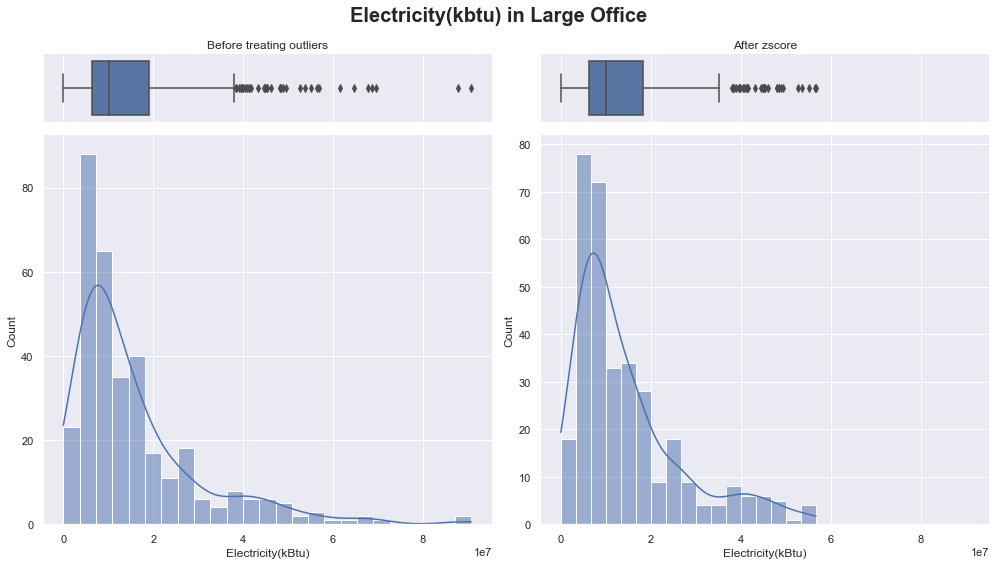

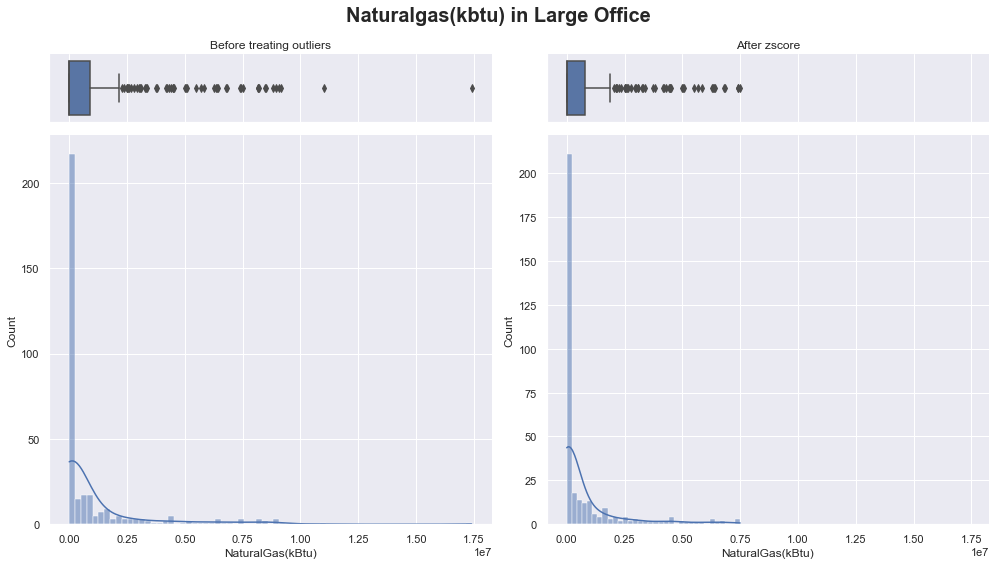

In [59]:
LIST_FEATURES_TO_PLOTT = ["Electricity(kBtu)", "NaturalGas(kBtu)"]
property_type = "Large Office"

df_temp = df_bebcs[df_bebcs["PrimaryPropertyType"] == property_type].copy()
df_temp_by_zscore = df_without_outliers[df_without_outliers["PrimaryPropertyType"] == property_type].copy()

for col in LIST_FEATURES_TO_PLOTT:

    # Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    fig, ((ax_box, ax_box_zscore), (ax_hist, ax_hist_zscore)) = \
                                                        plt.subplots(nrows=2, ncols=2, figsize=[14,8], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Title for the complete RR078466118RUfigure
    fig.suptitle((col.capitalize() + " in " + property_type), fontsize="x-large", fontweight="bold", size=20)

    # Assigning a graph to each ax
    ax_box.title.set_text("Before treating outliers")
    ax_box_zscore.title.set_text("After zscore")

    sns.boxplot(data=df_temp, x=col, ax=ax_box)
    sns.boxplot(data=df_temp_by_zscore, x=col, ax=ax_box_zscore)

    sns.histplot(data=df_temp, x=col, kde=True, ax=ax_hist)
    sns.histplot(data=df_temp_by_zscore, x=col, kde=True, ax=ax_hist_zscore)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")
    ax_box.set(yticks=[])
    ax_box_zscore.set(xlabel="")
    ax_box_zscore.set(yticks=[])

    plt.tight_layout()
    plt.savefig("img/outliers-" + (col[0:-5].capitalize()) + "-in-" + property_type + ".png")
    sns.despine(fig)

<div class="alert alert-block alert-success">
    Both percentiles and distributions appear similar
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5. Exploratory Data Analysis (Part I)</h3>
</div>
<br>
<div class="alert alert-block alert-info">
    We are just going to make an <b>Exploraty Data Analysis</b> based on the following<b>target variables</b>
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu)</b></li>
        <li><b>GHGEmissions(MetricTonsCO2e)</b></li>
    </ul>  
</div>

In [60]:
df_analysis(df_without_outliers, "df_without_outliers", type_analysis="complete")


Analysis of df_without_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 18 columns
- Total of NaN values:            1470
- Percentage of NaN:              2.49 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 593.7+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3277,1675,0,0.00000,15837.74611,1.00000,576.00000,21116.00000,24536.00000,50226.00000,13382.34425
6,NumberofFloors,int64,3277,44,0,0.00000,4.12756,1.00000,1.00000,2.00000,4.00000,99.00000,6.58991
1,DataYear,int64,3277,2,0,0.00000,2015.50168,2015.00000,2015.00000,2016.00000,2016.00000,2016.00000,0.50007
8,ZipCode,int64,3277,78,0,0.00000,58099.38785,0.00000,18390.00000,19584.00000,98109.00000,98199.00000,39791.33985
7,NumberofBuildings,int64,3277,17,0,0.00000,1.13457,1.00000,1.00000,1.00000,1.00000,111.00000,2.22852
9,Neighborhood,category,3277,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PropertyGFATotal,int64,3277,1646,0,0.00000,116356.52884,11285.00000,29636.00000,49299.00000,104786.00000,9320156.00000,252549.79665
4,YearBuilt,int64,3277,113,0,0.00000,1961.62588,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65412
3,renamed_PrimaryPropertyType,object,3277,9,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PrimaryPropertyType,object,3277,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.1. Initial analysis</h4>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.1 Primary Property type distribution</h5>
</div>

In [61]:
data_piechart = df_without_outliers["renamed_PrimaryPropertyType"].sort_values(ascending=False).value_counts().values
labels_piechart = df_without_outliers["renamed_PrimaryPropertyType"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB", "#7D6D5F", "#D095BF", "#EAEAF2", "#C1B37F"]
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0)

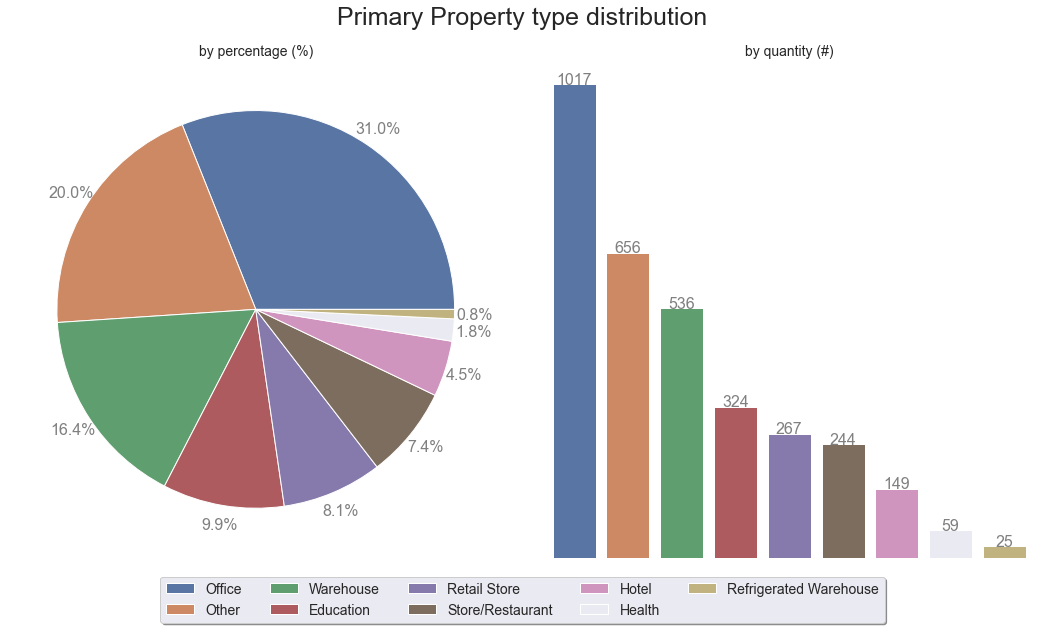

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,8])

fig.suptitle("Primary Property type distribution", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/primary-property-type-distribution.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.2  Comparison of the targets variables in each Property type</h5>
</div>

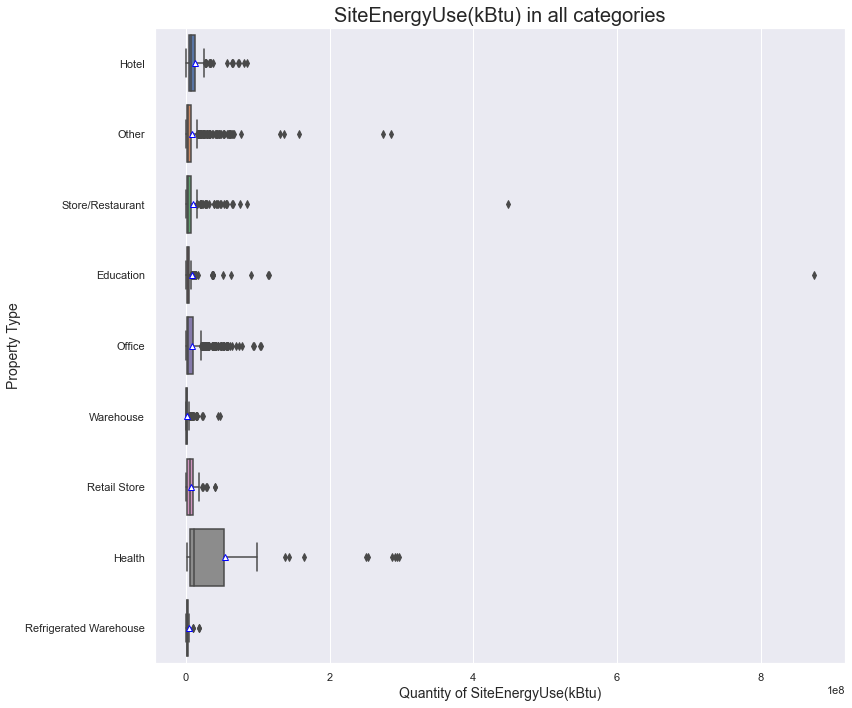

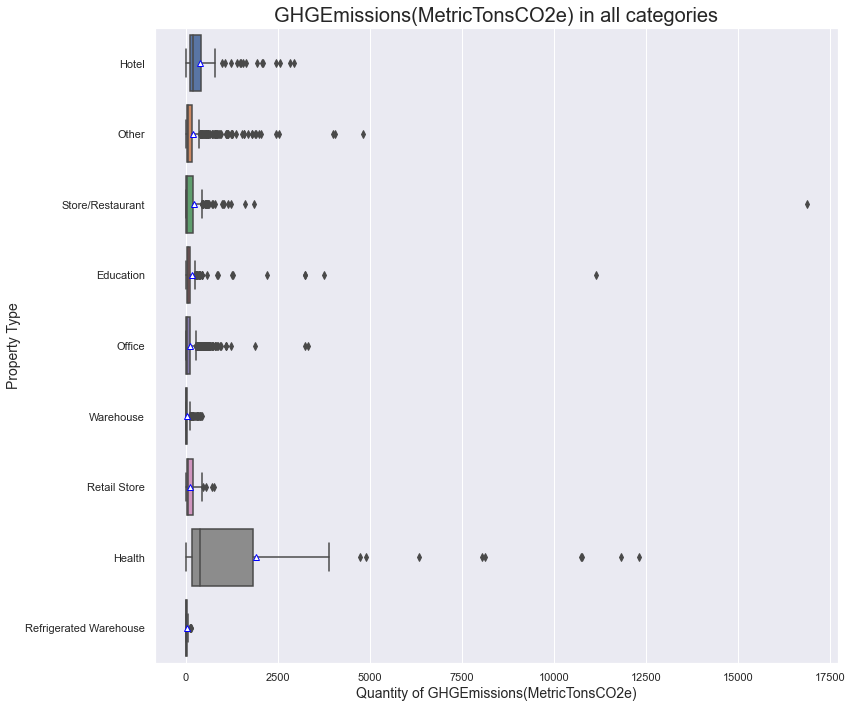

In [63]:
for var in TARGET_VARIABLES:
    if var != "ENERGYSTARScore":
        plt.figure(figsize=[12,10])
        sns.boxplot(x=df_without_outliers[var], y=df_without_outliers["renamed_PrimaryPropertyType"], orient="h", showmeans=True, 
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        plt.title(var + " in all categories", size=20)
        plt.ylabel("Property Type", size=14)
        plt.xlabel("Quantity of " + var, size=14)
        plt.tight_layout()
        plt.savefig("img/comparison-of-" + var + "-in-each-category.png")
        plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br/><br/>
    Building related to <b>Health</b> have a high <b>SiteEnergyUse(kBtu)</b> and <b>GHGEmissions(MetricTonsCO2e)</b>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.3  Comparison by Years</h5>
</div>

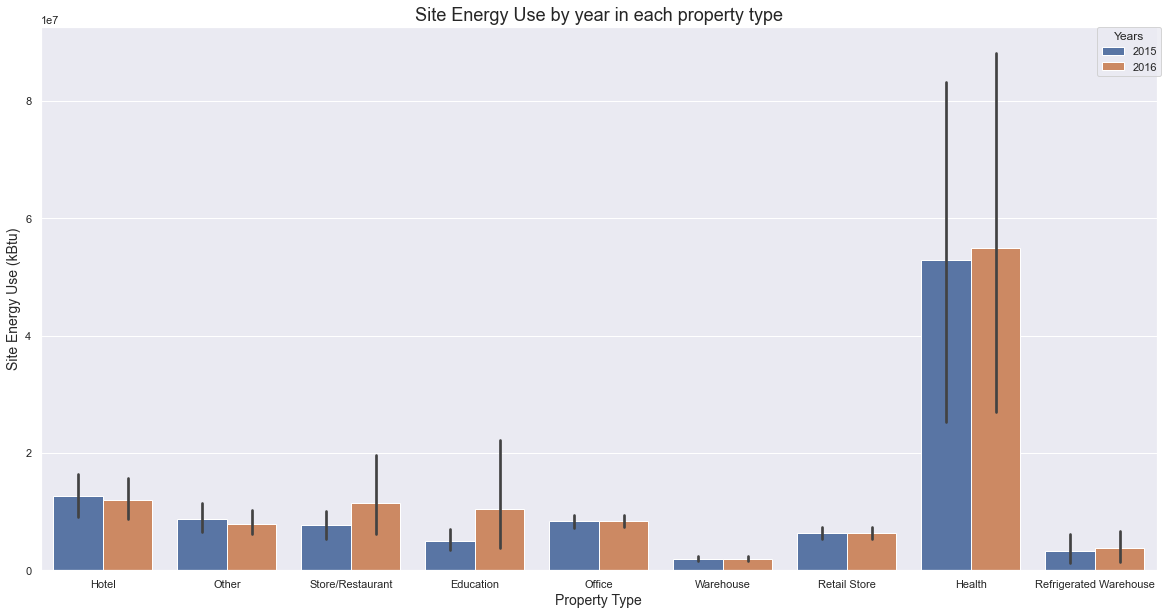

In [64]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x="renamed_PrimaryPropertyType", 
            y="SiteEnergyUse(kBtu)", 
            hue="DataYear", 
            data=df_without_outliers)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Years")
plt.ylabel("Site Energy Use (kBtu)", size=14)
plt.xlabel("Property Type", size=14)
plt.title("Site Energy Use by year in each property type", size=18)
plt.savefig("img\grouped-SiteEnergyUse-by-year.png")

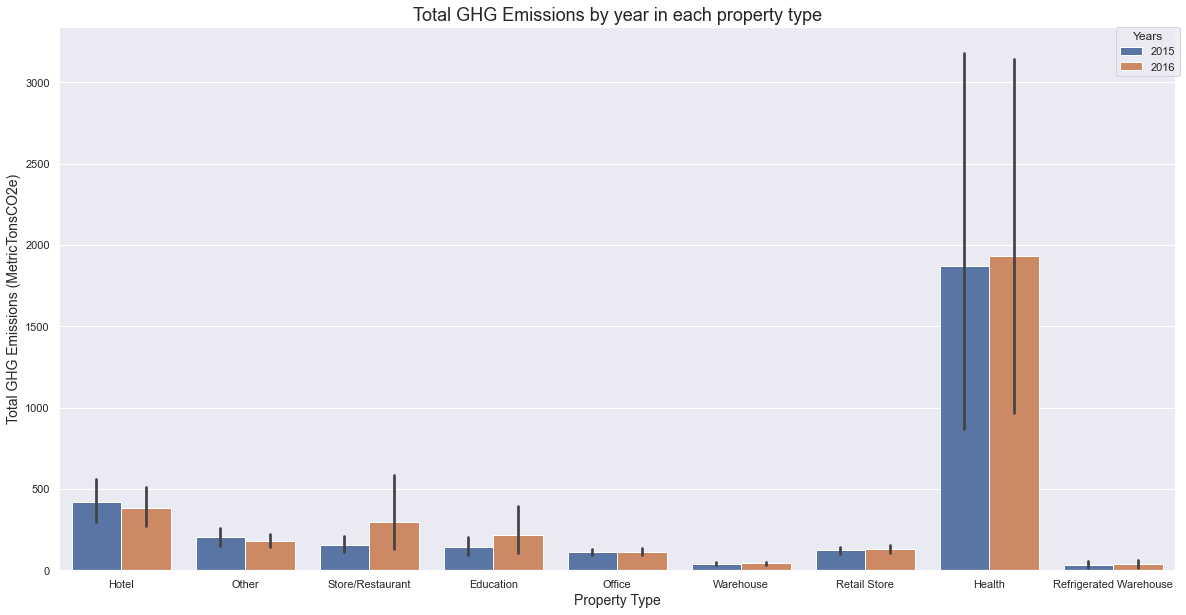

In [65]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x="renamed_PrimaryPropertyType", 
            y="GHGEmissions(MetricTonsCO2e)", 
            hue="DataYear", 
            data=df_without_outliers)
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Years")
plt.ylabel("Total GHG Emissions (MetricTonsCO2e)", size=14)
plt.xlabel("Property Type", size=14)
plt.title("Total GHG Emissions by year in each property type", size=18)
plt.savefig("img\grouped-GHGEmissions-by-year.png")

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br/><br/>
    Building related to <b>Health</b> have a high <b>SiteEnergyUse(kBtu)</b> and <b>GHGEmissions(MetricTonsCO2e)</b>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2. Univariate analysis</h4>
</div>
<br>
<div class="alert alert-block alert-info">
    We are are going to plot the <b>not missing-values</b> of the following target values
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu)</b></li>
        <li><b>GHGEmissions(MetricTonsCO2e)</b></li>
    </ul>  
</div>

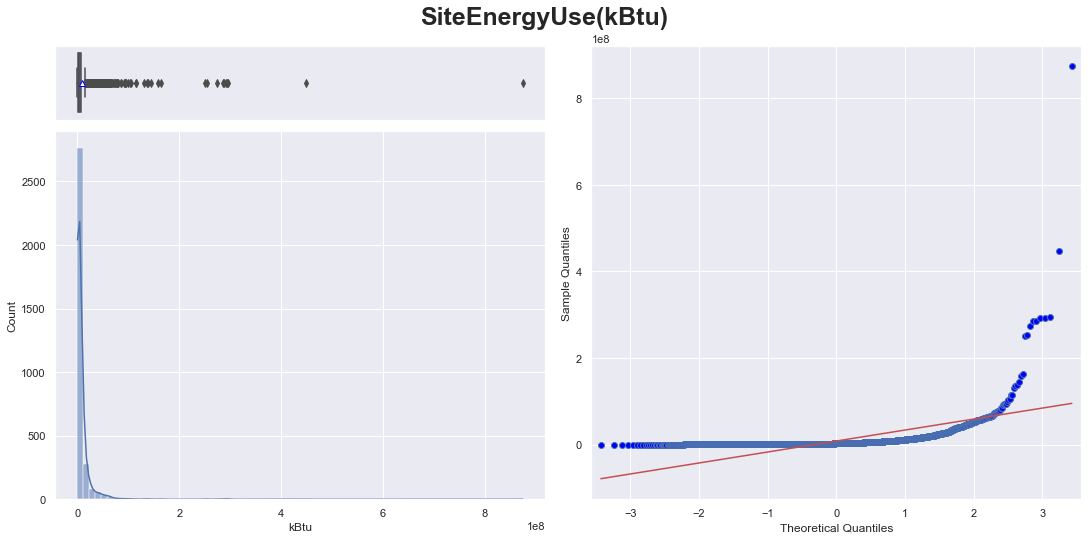


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,SiteEnergyUse(kBtu),Shapiro-Wilk,"Statistics=0.235, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,SiteEnergyUse(kBtu),D’Agostino’s K^2,"Statistics=6804.846, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,SiteEnergyUse(kBtu),Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


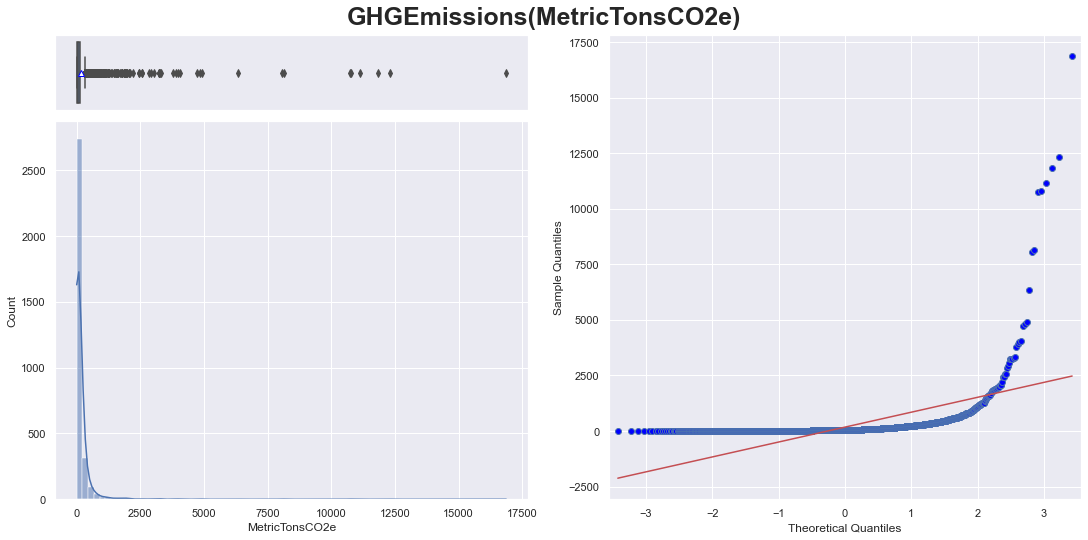


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,GHGEmissions(MetricTonsCO2e),Shapiro-Wilk,"Statistics=0.197, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,GHGEmissions(MetricTonsCO2e),D’Agostino’s K^2,"Statistics=6121.066, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,GHGEmissions(MetricTonsCO2e),Kolmogorov-Smirnov,"Statistics=0.966, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [66]:
# Filtering by non missing-values to can plot the QQplot
df_temp = pd.DataFrame(df_without_outliers[df_without_outliers[["SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"]].notnull().all(axis=1)])
        
for var in TARGET_VARIABLES:
    
    if var != "ENERGYSTARScore":

        fig = plt.figure(constrained_layout=True, figsize=[15,7])
        fig.suptitle(var, size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])

        # Boxplot
        boxplot = sns.boxplot(data=df_temp, x=df_temp[var], showmeans=True, ax=ax_box,
                              meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")

        # Histplot
        sns.histplot(data=df_temp, x=df_temp[var], bins=75,  kde=True,  ax=ax_hist)
        if var == "SiteEnergyUse(kBtu)":
            ax_hist.set(xlabel="kBtu")
        else:
            ax_hist.set(xlabel="MetricTonsCO2e")

        # QQplot
        qqplot(df_temp[var], line='s', ax=ax_qqplot)

        plt.savefig("img/qqplot-of-" + var + ".png")
        plt.show()

        print("\nMaking the Normality Test")
        print("---------------------------------")
        normality_test(df_temp[[var]])
        print("\n")

In [51]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu)</b> and <b>GHGEmissions(MetricTonsCO2e)</b> do not have a <b>Normal distribution</b></li>
        <li>Based on the distribution plot, we notice that <b>all values are very close</b> what remains to be a problem</li>
    </ul>  
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.2.1 Log Normalization target variables</h5>
</div>
<br>
<div class="alert alert-block alert-info">
    Based on the <b>Univariate analysis</b> where we note that <b>SiteEnergyUse(kBtu)</b> and <b>GHGEmissions(MetricTonsCO2e)</b> do not have a <b>Normal distribution</b>
    and <b>all their values are very close</b> so, we are going to aplly the <b>Natural Logarithmic transformation</b> in these variables to get a <b>better Normal distribution</b> 
    of these values
</div>

In [67]:
df_bebcs_log = df_without_outliers.copy()

<div class="alert alert-block alert-info">
    <b>To avoid missing-values</b>, we are going to apply <b>np.log(variable + 1)</b>
</div>

In [68]:
df_bebcs_log["SiteEnergyUse(kBtu)_log"] = np.log(df_bebcs_log["SiteEnergyUse(kBtu)"] + 1)
df_bebcs_log["GHGEmissions(MetricTonsCO2e)_log"] = np.log(df_bebcs_log["GHGEmissions(MetricTonsCO2e)"] + 1)

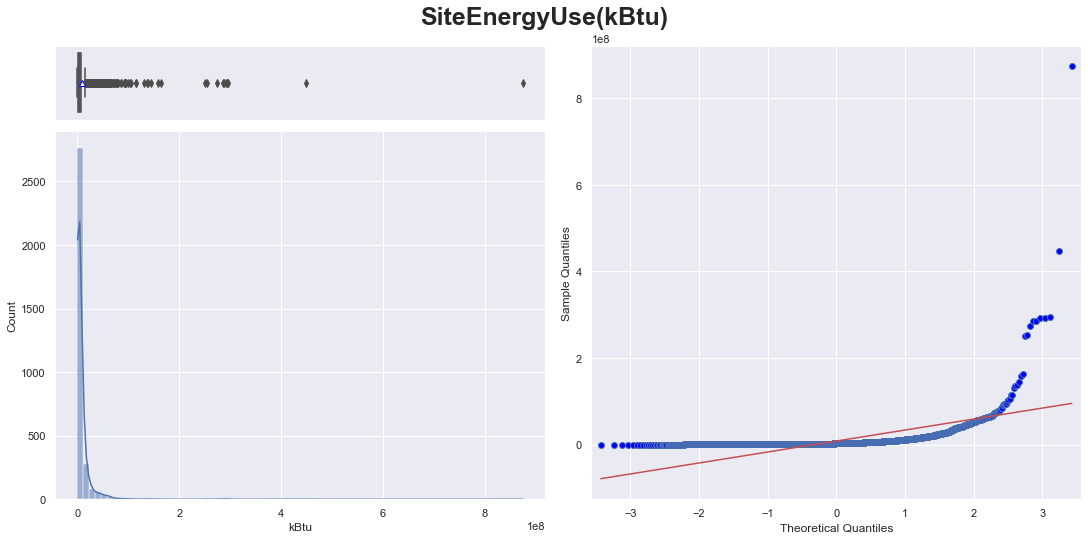


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,SiteEnergyUse(kBtu),Shapiro-Wilk,"Statistics=0.235, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,SiteEnergyUse(kBtu),D’Agostino’s K^2,"Statistics=6804.846, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,SiteEnergyUse(kBtu),Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


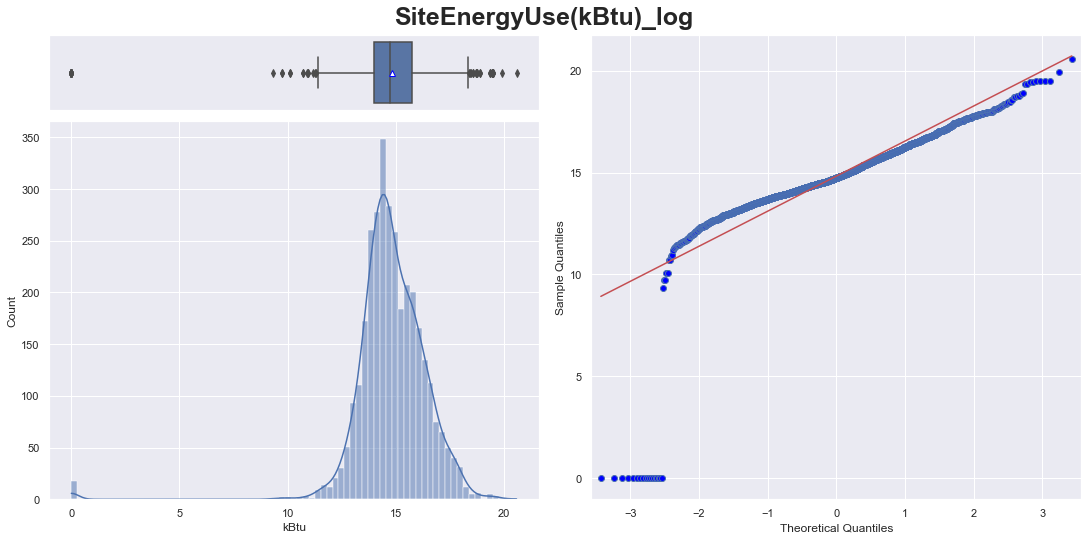


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,SiteEnergyUse(kBtu)_log,Shapiro-Wilk,"Statistics=0.778, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,SiteEnergyUse(kBtu)_log,D’Agostino’s K^2,"Statistics=2558.811, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,SiteEnergyUse(kBtu)_log,Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


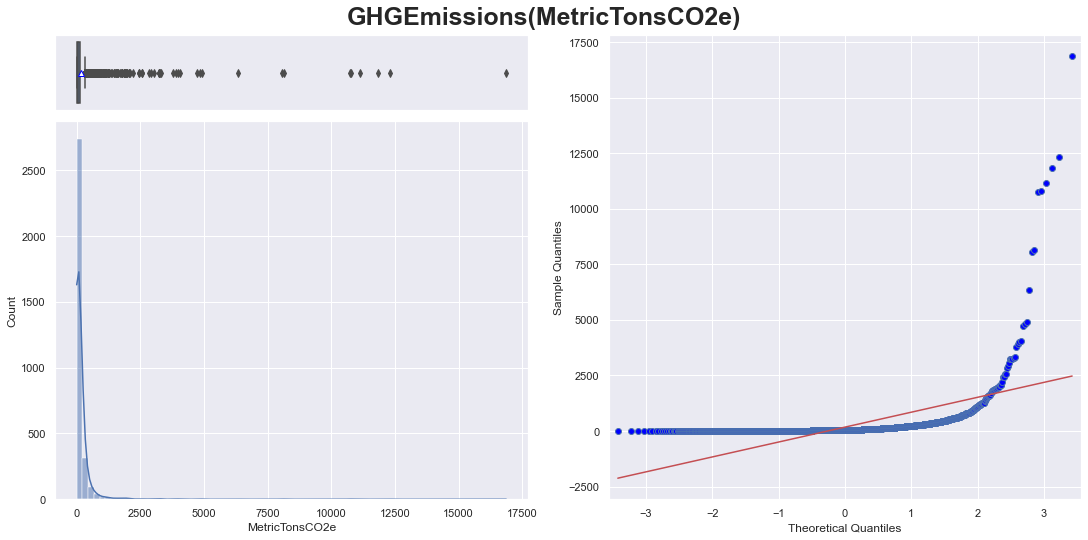


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,GHGEmissions(MetricTonsCO2e),Shapiro-Wilk,"Statistics=0.197, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,GHGEmissions(MetricTonsCO2e),D’Agostino’s K^2,"Statistics=6121.066, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,GHGEmissions(MetricTonsCO2e),Kolmogorov-Smirnov,"Statistics=0.966, p-value=0.000",Sample does not look Gaussian (reject H₀)


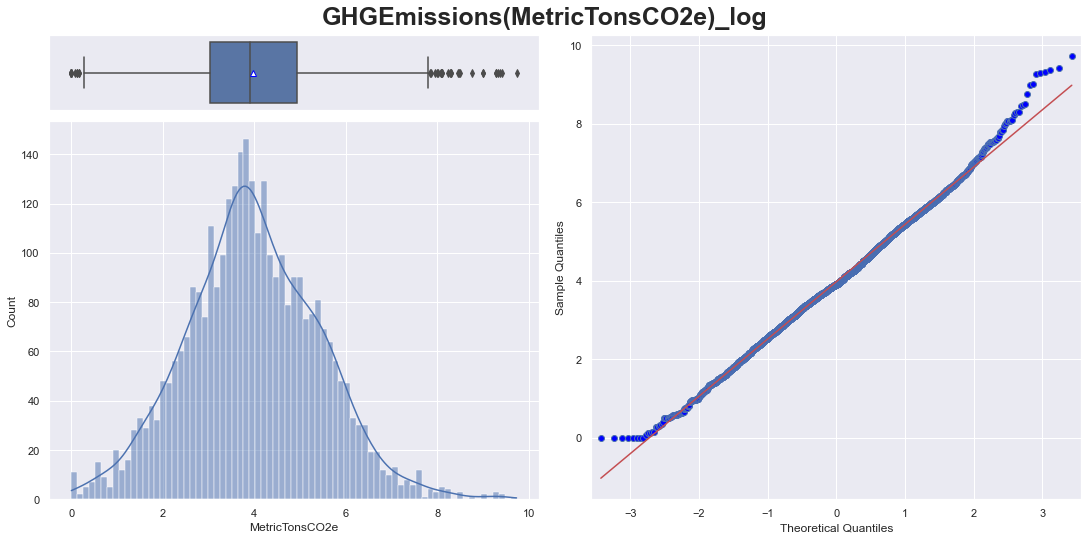


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,GHGEmissions(MetricTonsCO2e)_log,Shapiro-Wilk,"Statistics=0.997, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,GHGEmissions(MetricTonsCO2e)_log,D’Agostino’s K^2,"Statistics=20.378, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,GHGEmissions(MetricTonsCO2e)_log,Kolmogorov-Smirnov,"Statistics=0.897, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [54]:
# Filtering by non missing-values to can plot the QQplot
df_temp = pd.DataFrame(df_bebcs_log[df_bebcs_log[["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "GHGEmissions(MetricTonsCO2e)", "GHGEmissions(MetricTonsCO2e)_log"]].notnull().all(axis=1)])
        
for var in ["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "GHGEmissions(MetricTonsCO2e)", "GHGEmissions(MetricTonsCO2e)_log"]:
    
    fig = plt.figure(constrained_layout=True, figsize=[15,7])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=df_temp, x=df_temp[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=df_temp, x=df_temp[var], bins=75,  kde=True,  ax=ax_hist)
    if "SiteEnergyUse" in var:
        ax_hist.set(xlabel="kBtu")
    else:
        ax_hist.set(xlabel="MetricTonsCO2e")

    # QQplot
    qqplot(df_temp[var], line='s', ax=ax_qqplot)

    plt.savefig("img/qqplot-of-" + var + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(df_temp[[var]])
    print("\n")

<div class="alert alert-block alert-danger">
    <b>Flag Position</b>
</div>

In [55]:
XXXXXXXXXXXXXXXXXXXX

NameError: name 'XXXXXXXXXXXXXXXXXXXX' is not defined

<div class="alert alert-block alert-danger">
    <b>Flag Position</b>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.3. Bivariate analysis</h4>
</div>
<br>
<div class="alert alert-block alert-info">
    We are are going to plot the <b>not missing-values</b> of the target values
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu)</b></li>
        <li><b>GHGEmissions(MetricTonsCO2e)</b></li>
        <li><b>ENERGYSTARScore</b></li>
    </ul>  
</div>

In [ ]:
df_subset = pd.DataFrame(df_bebcs[df_bebcs[TARGET_VARIABLES].notnull().all(axis=1)])

list_variables, list_COEF, list_MSE, list_RMSE, list_R2SCORE = ([] for i in range(5))

for a, b in itertools.combinations(TARGET_VARIABLES, 2):
    
    # initializing Linear Regression by Pearson
    lr = LinearRegression()
    xtrain, xtest, ytrain, ytest = train_test_split(df_subset[[a]], df_subset[[b]], test_size=0.3)
    lr = LinearRegression()
    lr_baseline = lr.fit(xtrain, ytrain)
    pred_baseline = lr_baseline.predict(xtest)
    
    list_variables.append(a + " vs " + b)
    list_COEF.append(round(lr_baseline.coef_[0,0], 4))
    list_MSE.append(round(mean_squared_error(ytest, pred_baseline), 2))
    list_RMSE.append(round(math.sqrt(mean_squared_error(ytest, pred_baseline)), 2))
    list_R2SCORE.append(round(r2_score(ytest, pred_baseline), 2))
    
    # PLotting the graph
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    
    plt.suptitle(a + " vs " + b, fontsize=20, y=0.96)
    plt.title("Hotel",fontsize=16)
    plt.plot(xtest, ytest, 'bo', markersize = 5)
    plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
    plt.xlabel(a, size=14)
    plt.ylabel(b, size=14)
    plt.tight_layout()
    plt.savefig("img/correlation-" + a + "-vs-" + b + ".png")
    plt.show()
    
df_metrics_bivariate = pd.DataFrame({
    "variables":list_variables,
    "Coef.":list_COEF,
    "MSE":list_MSE,
    "RMSE":list_RMSE,
    "R2SCORE":list_R2SCORE
})
df_metrics_bivariate

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br>
    
    <ul style="list-style-type: square;">
        <li><b>Coefficient</b></li>
        <ul style="list-style-type: disc;">
           <li><b>SiteEnergyUse(kBtu) vs GHGEmissions(MetricTonsCO2e) 	</b> have a direct relationship</li> 
           <li><b>SiteEnergyUse(kBtu) vs ENERGYSTARScore</b> have and inverse relationship</li>
           <li><b>GHGEmissions(MetricTonsCO2e) vs ENERGYSTARScore</b> have and inverse relationship</li>
        </ul>
    </ul>
       
    <ul style="list-style-type: square;">
        <li><b>R² - Score</b><br>As we know, the closer the value of r2 is to 1, the greater the fit of the model to the variable we are trying to explain.</li>
        <ul style="list-style-type: disc;">
           <li>The <b>tightest values</b> based on <b>R²</b> are:</li>
           <ul style="list-style-type: circle;">
               <li>SiteEnergyUse(kBtu) vs GHGEmissions(MetricTonsCO2e): 0.86</li>
            </ul>
            <li>The <b>least values</b> based on <b>R²</b> are:</li>
           <ul style="list-style-type: circle;">
               <li>SiteEnergyUse(kBtu) vs ENERGYSTARScore: 0.00</li>
               <li>GHGEmissions(MetricTonsCO2e) vs ENERGYSTARScore: 0.01</li>
            </ul>
        </ul>
    </ul>
</div>

<div class="alert alert-block alert-danger">
    <b>Flag Position</b>
</div>